<a href="https://colab.research.google.com/github/wesslen/rag-workflow/blob/main/02_synthetic_queries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!uv pip install --system llama-index llama-index-embeddings-huggingface llama-index-llms-openai-like # llama-index-embeddings-instructor

In [2]:
import os
from google.colab import userdata

API_KEY = userdata.get('API_KEY')
BASE_URL = userdata.get('BASE_URL')

In [11]:
# take WF Code of Conduct
!wget -O text.txt https://r.jina.ai/https://www.wellsfargo.com/assets/pdf/about/corporate/code-of-conduct.pdf

--2025-01-11 02:43:07--  https://r.jina.ai/https://www.wellsfargo.com/assets/pdf/about/corporate/code-of-conduct.pdf
Resolving r.jina.ai (r.jina.ai)... 172.67.70.54, 104.26.11.242, 104.26.10.242, ...
Connecting to r.jina.ai (r.jina.ai)|172.67.70.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41541 (41K) [text/plain]
Saving to: ‘text.txt’

text.txt            100%[===================>]  40.57K  --.-KB/s    in 0.01s   

2025-01-11 02:43:08 (3.67 MB/s) - ‘text.txt’ saved [41541/41541]



In [37]:
import os
import sys
from typing import Dict, List, Optional, Tuple, Any
from dataclasses import dataclass
import logging
from pathlib import Path
import time
import json
import tiktoken
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
import traceback

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from openai import OpenAI

from llama_index.core import VectorStoreIndex, Document, Settings
from llama_index.llms.openai_like import OpenAILike
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core.evaluation import QueryResponseEvaluator

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    stream=sys.stdout
)
logger = logging.getLogger(__name__)

@dataclass
class EvalConfig:
    """Configuration for the evaluation process."""
    # File and model paths
    input_file: str
    model_path: str
    embed_model_name: str = "sentence-transformers/all-mpnet-base-v2"

    # API settings
    api_base: str = BASE_URL
    api_key: str = API_KEY

    # Chunking settings
    chunk_size: int = 50
    chunk_overlap: int = 20

    # Query generation settings
    query_temperature: float = 0.2
    queries_per_chunk: int = 1

    # LLM settings
    max_input_tokens: int = 1152  # Default for a smaller model
    token_buffer: int = 100  # Conservative buffer

    # Evaluation settings
    top_k: int = 5
    batch_size: int = 10

    # Debug settings
    debug: bool = True

    def __post_init__(self):
        """Validate configuration after initialization."""
        if self.max_input_tokens <= self.token_buffer:
            raise ValueError("max_input_tokens must be greater than token_buffer")
        if self.queries_per_chunk < 1:
            raise ValueError("queries_per_chunk must be at least 1")

class ProcessingError(Exception):
    """Custom error for processing failures."""
    pass

class RetrievalEvaluator:
    def __init__(self, config: EvalConfig):
        self.config = config
        self.stats = {
            'skipped_chunks': 0,
            'processed_chunks': 0,
            'failed_queries': 0,
            'successful_queries': 0,
            'errors': [],
            'token_stats': {
                'max_seen': 0,
                'average': 0,
                'total_tokens': 0
            }
        }
        self.setup_components()

    def setup_components(self):
        """Initialize all necessary components with robust error checking."""
        try:
            # Setup encoding for token counting
            self.tokenizer = tiktoken.get_encoding("cl100k_base")

            # Calculate effective token limits
            self.effective_max_tokens = int(self.config.max_input_tokens * 0.8)  # 20% safety margin

            # Setup base prompt template
            self.system_prompt = """You are an assistant helping to evaluate an information retrieval system by generating realistic search queries.
            For each text chunk provided, generate a specific query (under 10 words) that would be used to retrieve that chunk from a larger document.
            Make the query specific enough to target the chunk's key information but natural sounding, as if a Wells Fargo employee was searching the Employee Code of Conduct.
            Only output the query itself - no other text, explanation or commentary.
            The query should directly relate to the main topic or requirement discussed in the chunk.
            Do not include double quotes.
            """

            self.user_prompt_template = """Text chunk: {chunk}

            Query: """

            # Calculate and validate base prompt tokens
            self.base_prompt_tokens = self.count_tokens(self.system_prompt) + self.count_tokens(self.user_prompt_template)
            self.validate_prompt_template()

            # Setup components
            self.embed_model = HuggingFaceEmbedding(
                model_name=self.config.embed_model_name
            )

            self.client = OpenAI(
                base_url=self.config.api_base,
                api_key=self.config.api_key
            )

            self.node_parser = SimpleNodeParser.from_defaults(
                chunk_size=self.config.chunk_size,
                chunk_overlap=self.config.chunk_overlap
            )

            # Configure global settings
            # Settings.llm = self.llm
            Settings.embed_model = self.embed_model
            Settings.node_parser = self.node_parser

            logger.info(f"""
            Initialization complete:
            - Base prompt tokens: {self.base_prompt_tokens}
            - Effective max tokens: {self.effective_max_tokens}
            - Available tokens for content: {self.effective_max_tokens - self.base_prompt_tokens - self.config.token_buffer}
            """)

        except Exception as e:
            logger.error(f"Failed to initialize components: {str(e)}")
            raise

    def validate_prompt_template(self):
        """Validate that the prompt template isn't too large."""
        # Count tokens for both prompts
        system_tokens = self.count_tokens(self.system_prompt)
        user_tokens = self.count_tokens(self.user_prompt_template)
        total_tokens = system_tokens + user_tokens

        if total_tokens > self.effective_max_tokens * 0.3:
            raise ValueError(f"Combined prompts too large: {total_tokens} tokens")

    def count_tokens(self, text: str) -> int:
        """Count tokens in text using tiktoken."""
        try:
            return len(self.tokenizer.encode(text))
        except Exception as e:
            logger.error(f"Token counting failed: {str(e)}")
            self.track_error("token_count_error", {"text_length": len(text), "error": str(e)})
            return float('inf')  # Conservative approach - treat as too long

    def track_error(self, error_type: str, details: Dict[str, Any]):
        """Track detailed error information."""
        error_info = {
            'type': error_type,
            'timestamp': time.time(),
            'details': details,
            'traceback': traceback.format_exc()
        }
        self.stats['errors'].append(error_info)

    def debug_token_counts(self, chunk: str):
        """Debug token counting for a chunk."""
        if self.config.debug:
            prompt = self.user_prompt_template.format(chunk=chunk)
            logger.debug(f"""
                Debug token counts:
                - System prompt: {self.count_tokens(self.system_prompt)}
                - User prompt template: {self.count_tokens(self.user_prompt_template)}
                - Chunk: {self.count_tokens(chunk)}
                - Full user prompt: {self.count_tokens(prompt)}
                - Buffer: {self.config.token_buffer}
                - Max allowed: {self.effective_max_tokens}
            """)

    def is_chunk_processable(self, chunk: str) -> bool:
        """Check if chunk can be processed within token limits."""
        chunk_tokens = self.count_tokens(chunk)
        total_tokens = self.base_prompt_tokens + chunk_tokens

        # Update token statistics
        self.stats['token_stats']['max_seen'] = max(
            self.stats['token_stats']['max_seen'],
            total_tokens
        )
        self.stats['token_stats']['total_tokens'] += total_tokens

        # Add extra buffer for message formatting
        estimated_total = total_tokens + self.config.token_buffer

        is_processable = estimated_total <= self.effective_max_tokens

        if not is_processable:
            logger.info(f"""
                Chunk exceeds token limits:
                - Chunk tokens: {chunk_tokens}
                - Base prompt tokens: {self.base_prompt_tokens}
                - Estimated total: {estimated_total}
                - Limit: {self.effective_max_tokens}
                - First 100 chars: {chunk[:100]}...
            """)

        return is_processable

    def process_large_chunk(self, chunk: str) -> List[str]:
        """Handle chunks that are too large by taking a subset."""
        if not self.is_chunk_processable(chunk):
            # Take first N tokens that fit within limits
            tokens = self.tokenizer.encode(chunk)
            safe_token_limit = self.effective_max_tokens - self.base_prompt_tokens - self.config.token_buffer
            truncated_tokens = tokens[:safe_token_limit]
            truncated_chunk = self.tokenizer.decode(truncated_tokens)

            logger.info(f"Truncated chunk from {len(tokens)} to {len(truncated_tokens)} tokens")

            return self.generate_queries(truncated_chunk)
        return self.generate_queries(chunk)

    @retry(
        stop=stop_after_attempt(3),
        wait=wait_exponential(multiplier=1, min=4, max=10),
        retry=retry_if_exception_type(Exception)
    )
    def generate_query_with_retry(self, chunk: str) -> Optional[str]:
        """Generate a query with retry logic."""
        try:
            if not self.is_chunk_processable(chunk):
                return None

            response = self.client.chat.completions.create(
                model=self.config.model_path,
                messages=[
                    {"role": "system", "content": self.system_prompt},
                    {"role": "user", "content": self.user_prompt_template.format(chunk=chunk)}
                ],
                temperature=self.config.query_temperature
            )
            self.stats['successful_queries'] += 1
            return response.choices[0].message.content.strip()
        except Exception as e:
            logger.warning(f"Failed to generate query: {str(e)}")
            self.stats['failed_queries'] += 1
            self.track_error("query_generation_error", {
                "chunk_length": len(chunk),
                "error": str(e)
            })
            return None

    def generate_queries(self, chunk: str) -> List[str]:
        """Generate queries for a given chunk."""
        self.debug_token_counts(chunk)

        if not self.is_chunk_processable(chunk):
            self.stats['skipped_chunks'] += 1
            logger.warning(f"""
                Skipping chunk due to length:
                - Characters: {len(chunk)}
                - Tokens: {self.count_tokens(chunk)}
            """)
            return []

        self.stats['processed_chunks'] += 1
        queries = []
        for _ in range(self.config.queries_per_chunk):
            query = self.generate_query_with_retry(chunk)
            if query:
                queries.append(query)

        return queries

    def load_and_index_document(self) -> Tuple[VectorStoreIndex, List[Document]]:
        """Load document and create index."""
        logger.info("Loading and indexing document...")

        try:
            with open(self.config.input_file, 'r') as f:
                text = f.read()

            documents = [Document(text=text)]
            nodes = self.node_parser.get_nodes_from_documents(documents)

            # Create index with local settings
            index = VectorStoreIndex.from_documents(
                documents,
                embed_model=self.embed_model,
                transformations=[self.node_parser]
            )

            return index, nodes

        except Exception as e:
            logger.error(f"Failed to load and index document: {str(e)}")
            self.track_error("indexing_error", {"error": str(e)})
            raise

    def evaluate_retrieval(self, index: VectorStoreIndex, nodes: List[Document]) -> Dict:
        """Evaluate retrieval performance."""
        logger.info("Starting retrieval evaluation...")

        query_engine = index.as_query_engine(
            llm=None,
            similarity_top_k=self.config.top_k
        )

        results = {
            'hit_at_k': [],
            'queries': [],
            'original_chunks': [],
            'retrieval_times': [],
            'skipped_chunks': [],
            'stats': self.stats
        }

        for node in tqdm(nodes, desc="Evaluating chunks"):
            # Try to process the chunk, potentially with truncation
            queries = self.process_large_chunk(node.text)

            if not queries:
                results['skipped_chunks'].append({
                    'chunk': node.text[:200] + "...",  # Only store preview
                    'reason': 'Token limit exceeded or query generation failed',
                    'token_count': self.count_tokens(node.text)
                })
                continue

            for query in queries:
                try:
                    start_time = time.time()
                    response = query_engine.query(query)
                    retrieval_time = time.time() - start_time

                    retrieved_texts = [n.node.text for n in response.source_nodes]
                    is_found = node.text in retrieved_texts

                    results['hit_at_k'].append(int(is_found))
                    results['queries'].append(query)
                    results['original_chunks'].append(node.text)
                    results['retrieval_times'].append(retrieval_time)

                except Exception as e:
                    logger.error(f"Error during retrieval: {str(e)}")
                    self.track_error("retrieval_error", {
                        "query": query,
                        "error": str(e)
                    })

        # Update average token stats
        if self.stats['processed_chunks'] > 0:
            self.stats['token_stats']['average'] = (
                self.stats['token_stats']['total_tokens'] /
                self.stats['processed_chunks']
            )

        return results

    def visualize_results(self, results: Dict):
        """Create visualizations of the evaluation results."""
        if not results['hit_at_k']:
            logger.warning("No results to visualize - all chunks may have been skipped")
            return

        hit = np.mean(results['hit_at_k'])
        avg_time = np.mean(results['retrieval_times'])

        print("\nEvaluation Statistics:")
        print(f"Overall Hit@{self.config.top_k}: {hit:.3f}")
        print(f"Average retrieval time: {avg_time:.3f} seconds")

        print(f"\nProcessing Statistics:")
        print(f"Processed chunks: {self.stats['processed_chunks']}")
        print(f"Skipped chunks: {self.stats['skipped_chunks']}")
        print(f"Successful queries: {self.stats['successful_queries']}")
        print(f"Failed queries: {self.stats['failed_queries']}")

        print(f"\nToken Statistics:")
        print(f"Max tokens seen: {self.stats['token_stats']['max_seen']}")
        print(f"Average tokens: {self.stats['token_stats']['average']:.1f}")

        if self.stats['errors']:
            print(f"\nEncountered {len(self.stats['errors'])} errors")

        # Plot timing distribution
        plt.figure(figsize=(10, 5))
        plt.hist(results['retrieval_times'], bins=30)
        plt.title('Distribution of Retrieval Times')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Count')
        plt.show()

    def run_evaluation(self):
        """Run the complete evaluation pipeline."""
        # Load and index document
        index, nodes = self.load_and_index_document()

        # Run evaluation
        results = self.evaluate_retrieval(index, nodes)

        # Visualize results
        self.visualize_results(results)

        # Save results
        output_path = Path(self.config.input_file).with_suffix('.eval_results.json')
        with open(output_path, 'w') as f:
            json.dump(results, f)

        return results



Evaluating chunks:   0%|          | 0/220 [00:00<?, ?it/s]


Evaluation Statistics:
Overall Hit@5: 0.791
Average retrieval time: 0.845 seconds

Processing Statistics:
Processed chunks: 220
Skipped chunks: 0
Successful queries: 220
Failed queries: 0

Token Statistics:
Max tokens seen: 191
Average tokens: 505.5


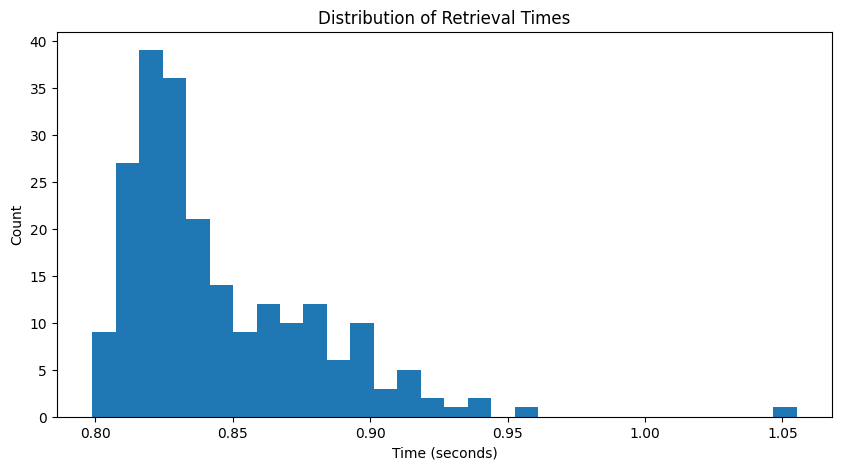

In [38]:
config = EvalConfig(
    input_file="text.txt",
    model_path="/models/NousResearch/Meta-Llama-3.1-8B-Instruct",
    max_input_tokens=1000  # Set based on your model's context window
)

evaluator = RetrievalEvaluator(config)
results = evaluator.run_evaluation()

In [39]:
import json
import pandas as pd
import os

def process_json_to_csvs(json_data, output_dir='output'):
    """
    Process JSON data and create multiple CSV files for different components.
    Now includes original chunks and ranking information in hit_queries.csv.

    Parameters:
    json_data (dict): Parsed JSON data
    output_dir (str): Directory to save CSV files
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1. Create hit_queries.csv with enhanced information
    hit_data = pd.DataFrame({
        'query': json_data['queries'],
        'original_chunk': json_data['original_chunks'],
        'hit_score': json_data['hit_at_k'],
        'original_chunk_found': [bool(score) for score in json_data['hit_at_k']],
        'rank': ['1' if score == 1 else 'Not in top k' if score == 0 else 'Unknown'
                for score in json_data['hit_at_k']],
        'retrieval_time': json_data['retrieval_times']
    })
    hit_data.to_csv(f'{output_dir}/hit_queries.csv', index=False)

    # 2. Create original_chunks.csv
    chunks_data = pd.DataFrame({
        'chunk_id': range(len(json_data['original_chunks'])),
        'content': json_data['original_chunks']
    })
    chunks_data.to_csv(f'{output_dir}/original_chunks.csv', index=False)

    # 3. Create retrieval_times.csv
    retrieval_data = pd.DataFrame({
        'chunk_id': range(len(json_data['retrieval_times'])),
        'retrieval_time': json_data['retrieval_times']
    })
    retrieval_data.to_csv(f'{output_dir}/retrieval_times.csv', index=False)

    # 4. Create stats.csv - flattening the stats dictionary
    stats_dict = json_data['stats']
    # Handle nested token_stats
    token_stats = stats_dict.pop('token_stats')
    stats_dict.update({f'token_{k}': v for k, v in token_stats.items()})
    # Convert errors list to string to store in CSV
    stats_dict['errors'] = ','.join(map(str, stats_dict['errors']))

    stats_df = pd.DataFrame([stats_dict])
    stats_df.to_csv(f'{output_dir}/stats.csv', index=False)

    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total queries processed: {len(hit_data)}")
    print(f"Queries where original chunk was found: {sum(hit_data['original_chunk_found'])}")
    print(f"Average retrieval time: {hit_data['retrieval_time'].mean():.3f} seconds")

def main():
    """
    Main function to read JSON from file and process it.
    """
    try:
        # Read the JSON data from the file
        with open('text.eval_results.json', 'r', encoding='utf-8') as file:
            json_data = json.load(file)

        # Process the JSON data and create CSV files
        process_json_to_csvs(json_data)

        print("\nCSV files have been created successfully in the 'output' directory:")
        print("1. hit_queries.csv - Contains queries, original chunks, and retrieval metrics")
        print("2. original_chunks.csv - Contains the original text chunks")
        print("3. retrieval_times.csv - Contains retrieval times for each chunk")
        print("4. stats.csv - Contains processing statistics")

    except FileNotFoundError:
        print("Error: text.eval_results.json file not found")
    except json.JSONDecodeError:
        print("Error: Invalid JSON format in the input file")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


Summary Statistics:
Total queries processed: 220
Queries where original chunk was found: 174
Average retrieval time: 0.845 seconds

CSV files have been created successfully in the 'output' directory:
1. hit_queries.csv - Contains queries, original chunks, and retrieval metrics
2. original_chunks.csv - Contains the original text chunks
3. retrieval_times.csv - Contains retrieval times for each chunk
4. stats.csv - Contains processing statistics
